In [ ]:
#importing necessary libraries

import os
import tensorflow as tf
import numpy
import matplotlib.pylab as plt
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
#downloading and extracting fruit 360 dataset from Kaggle

dataset = tf.keras.utils.get_file(origin="https://storage.googleapis.com/kaggle-data-sets/5857%2F1166105%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1598630842&Signature=VrU3W%2B%2BFkVEJx7JTSPicNc8sTnkGzlaiu4lBkgMnxYnpPUnVFzLaOI7ai2NES9GrV9n1ZVtMMw2Xku1fLtGwLwhLFDSMOk8iwFI%2Foagl9a1YDIdVJIbBWUxrJn6DdDccrb50oIFzoHFWwK0jzmqacg0CCy4EboLRY6YPmOwNCwoiXZ04CsRlQrdqON1kq4pa8Bvg%2FHD5xx0ZvDjrQWLyY1e%2B0eVxX%2Bk9L7gPxdsnCEceQAXWhDez%2BmHJDcqtdxKvFNvEkQyhw9Vm%2FEWdXRZVLD7fuK0FQCn0zXymapZHjJqvK9EHyhzjiO96yx1ggZnTwwbb3A7NCjHRfeZRSjQSsQ%3D%3D",
                                   fname="fruits-360.zip", extract=True)


#setting the base directory which will be used to get the file contents
base_dir, _ = os.path.splitext(dataset)

796745728/796742678 [==============================] - 15s 0us/step


In [ ]:
training_directory = os.path.join(base_dir, 'Training')
validation_directory = os.path.join(base_dir, 'Test')


#as dataset image size is 100X100 pixels, fetching model which accepts input size of upto 128 pixels
image_size = 128
batch_size = 32



#data augmentation of training dataset
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

training_generator = train_datagen.flow_from_directory(directory=training_directory, target_size=(image_size, image_size), batch_size=batch_size)

Found 67692 images belonging to 131 classes.


In [ ]:

#data augmentation of validation dataset
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(directory=validation_directory, target_size=(image_size, image_size), batch_size=batch_size)

IMG_SHAPE = (image_size, image_size, 3)


#importing model from Keras
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = False

Found 22688 images belonging to 131 classes.
17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
#adding Fully connected layers for model
model_new = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(131, activation='sigmoid')
])
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 131)               134275    
Total params: 3,363,139
Trainable params: 134,275
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:

#compiling model with Adam optimizer
model_new.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
epochs = 25

#uncomment to compile with RMS prop optimizer
# model_new.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
#  loss='binary_crossentropy',
#  metrics=['accuracy'])



steps_per_epoch = numpy.ceil(training_generator.n / batch_size)
validation_steps = numpy.ceil(validation_generator.n / batch_size)

In [ ]:

"""
training the model with 25 epochs
storing the model data as a history object
used for plotting graphs
"""
model_data = model_new.fit(x=training_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps).history

2116/2116 [==============================] - 76s 36ms/step - loss: 0.4301 - accuracy: 0.9265 - val_loss: 0.3259 - val_accuracy: 0.9222


hist {'loss': [0.43007925152778625], 'accuracy': [0.9264905452728271], 'val_loss': [0.32588550448417664], 'val_accuracy': [0.9221615195274353]}


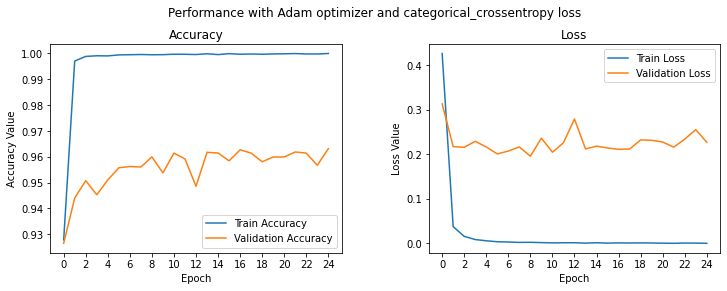

In [ ]:

#plotting graphs for model accuracy and loss values
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance with Adam optimizer and categorical_crossentropy loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,25))
ax1.plot(epoch_list, model_data["accuracy"], label='Train Accuracy')
ax1.plot(epoch_list, model_data["val_accuracy"], label='Validation Accuracy')
ax1.set_xticks(numpy.arange(0, 25, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, model_data['loss'], label='Train Loss')
ax2.plot(epoch_list, model_data['val_loss'], label='Validation Loss')
ax2.set_xticks(numpy.arange(0, 25, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#converting model to TFlite so that it can be easily integrated with the application
saved_model_dir = '/content/TfliteModel'
tf.saved_model.save(model_new, saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open('finalModel.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/TFLite/assets


In [ ]:
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 131)               134275    
Total params: 3,363,139
Trainable params: 134,275
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
#making a txt file of the class names from the training genrator
labels = '\n'.join(sorted(training_generator.class_indices.keys()))
with open('ModelLabels.txt', 'w') as f:
    f.write(labels)